## ENSEMBLE MODEL (LR + NB + SVM + XGB + LSTM)
METALEARNER : XGBOOST

In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# Load Logistic Regression model and vectorizer
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

# Load SVM model and vectorizer
with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

# Load XGBoost model, vectorizer, and label encoder
with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# Load LSTM model, tokenizer, and label encoder
lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

# Load Naive Bayes model and vectorizer
with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' column exists
if 'cleaned_text' not in data.columns:
    raise ValueError("The dataset must have a 'cleaned_text' column.")

# Remove rows with missing values in 'cleaned_text'
data.dropna(subset=['cleaned_text'], inplace=True)

# Split features and target
X_test = data['cleaned_text']
y_test = data['mental_health_issue']

# Encode target labels
y_test = label_encoder.transform(y_test)

# Process the text for each model
X_test_lr = lr_vectorizer.transform(X_test)  # Logistic Regression vectorizer
X_test_svm = svm_vectorizer.transform(X_test)  # SVM vectorizer
X_test_xgb = tfidf_vectorizer.transform(X_test)  # XGBoost vectorizer
X_test_nb = nb_vectorizer.transform(X_test)  # Naive Bayes vectorizer
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)  # LSTM tokenizer

# Pad sequences for LSTM
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get predictions from the base models
lr_predictions_proba = lr_model.predict_proba(X_test_lr)  # Logistic Regression probabilities
svm_predictions_proba = svm_model.predict_proba(X_test_svm)  # SVM probabilities
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)  # XGBoost probabilities
nb_predictions_proba = nb_model.predict_proba(X_test_nb)  # Naive Bayes probabilities
lstm_predictions_proba = lstm_model.predict(X_test_lstm)  # LSTM probabilities

# Stack the predictions of all models to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    xgb_predictions_proba,
    nb_predictions_proba,
    lstm_predictions_proba
))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    stacked_features, y_test, test_size=0.2, random_state=42, stratify=y_test
)

# Train the meta-learner (XGBoost as the meta-learner)
meta_learner_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
meta_learner_xgb.fit(X_train, y_train)

# Save the trained XGBoost meta-learner
with open('meta_learner_xgb.pkl', 'wb') as file:
    pickle.dump(meta_learner_xgb, file)

# Predict using the XGBoost meta-learner
final_predictions_xgb = meta_learner_xgb.predict(X_test)

# Evaluate the XGBoost ensemble model
accuracy_xgb = accuracy_score(y_test, final_predictions_xgb)
report_xgb = classification_report(y_test, final_predictions_xgb, target_names=label_encoder.classes_)

print(f"XGBoost Meta-Learner Accuracy: {accuracy_xgb * 100:.2f}%")
print("Classification Report (XGBoost):\n", report_xgb)
print("Confusion Matrix (XGBoost):\n", confusion_matrix(y_test, final_predictions_xgb))

# Calculate the mean and standard deviation of validation accuracies
cross_val_accuracies = cross_val_score(
    meta_learner_xgb, X_test, y_test, cv=5, scoring='accuracy'
)

mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")

581/581 ━━━━━━━━━━━━━━━━━━━━ 47s 81ms/step


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:12:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Meta-Learner Accuracy: 97.52%
Classification Report (XGBoost):
               precision    recall  f1-score   support

     anxiety       0.97      0.97      0.97       400
     bipolar       0.94      0.91      0.92       388
  depression       0.96      0.95      0.96       392
      normal       0.99      0.99      0.99      2136
        ptsd       0.97      0.97      0.97       397

    accuracy                           0.98      3713
   macro avg       0.96      0.96      0.96      3713
weighted avg       0.98      0.98      0.98      3713

Confusion Matrix (XGBoost):
 [[ 389    0    5    1    5]
 [   3  353    5   24    3]
 [   9    6  373    0    4]
 [   0   15    2 2119    0]
 [   2    2    4    2  387]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:12:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:12:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:12:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:12:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:12:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-Validation Accuracies: [0.9730821  0.97711978 0.9730821  0.97843666 0.97708895]
Mean Validation Accuracy: 97.58%
Validation Accuracy Std Dev: 0.22%


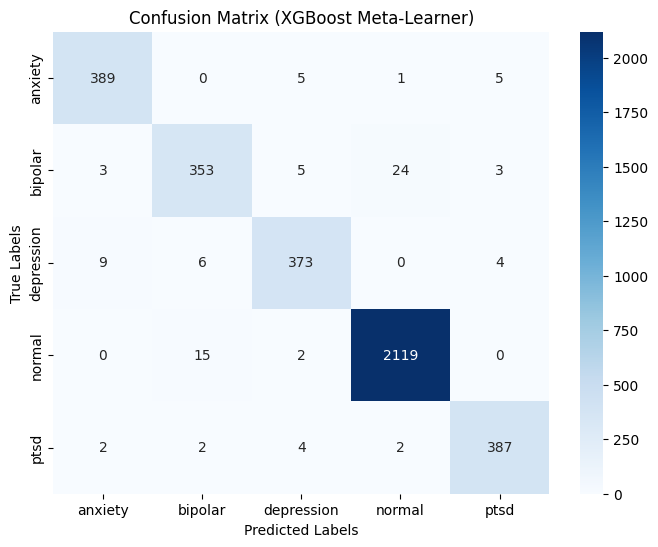

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (XGBoost Meta-Learner)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


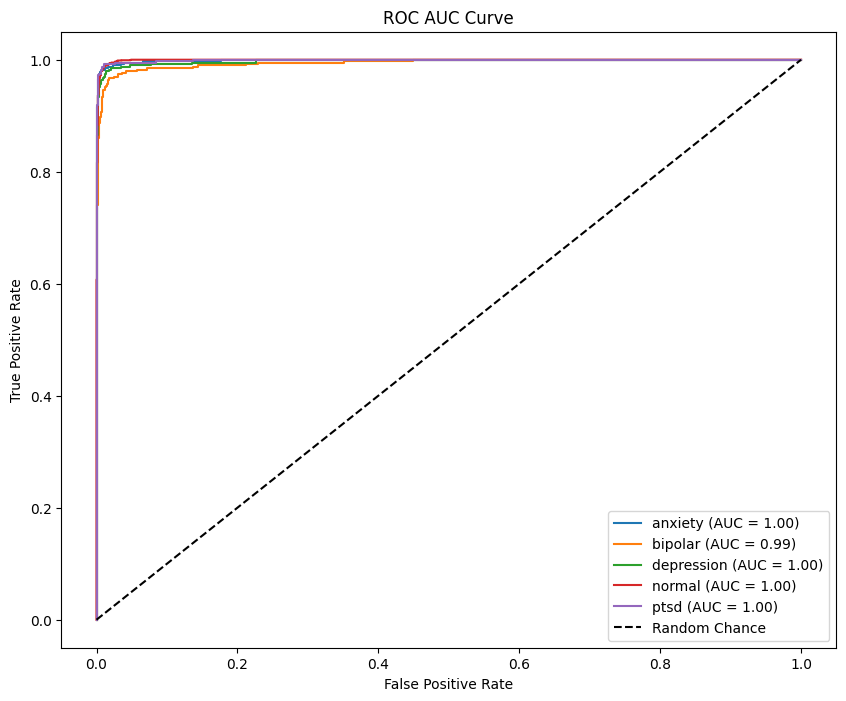

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))

# Calculate probabilities for the test set only
final_predictions_proba = meta_learner_xgb.predict_proba(X_test) # Changed stacked_features to X_test

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], final_predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()